In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
from glob import glob
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

In [2]:
batch_size = 32
img_height = 160
img_width = 160
channel_n = 3

In [3]:
import pathlib
data_dir = pathlib.Path('/Users/syshin/Desktop/Himedia/Himedia_project/image_classification/archive (1)/images/images') 


In [4]:
data_dir.glob('*.*')

<generator object Path.glob at 0x2bad6ec80>

In [5]:
image_count = len(list(data_dir.glob('*.*')))
print(image_count)

1


In [6]:
from tensorflow.keras.preprocessing import *

In [7]:
train_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 35093 files belonging to 4 classes.
Using 28075 files for training.
Metal device set to: Apple M1 Pro


2022-06-17 11:49:34.061326: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-17 11:49:34.061950: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
val_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 35093 files belonging to 4 classes.
Using 7018 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['architecure', 'art and culture', 'food and drinks', 'travel and adventure']


## 데이터 시각화

2022-06-17 11:49:34.933081: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


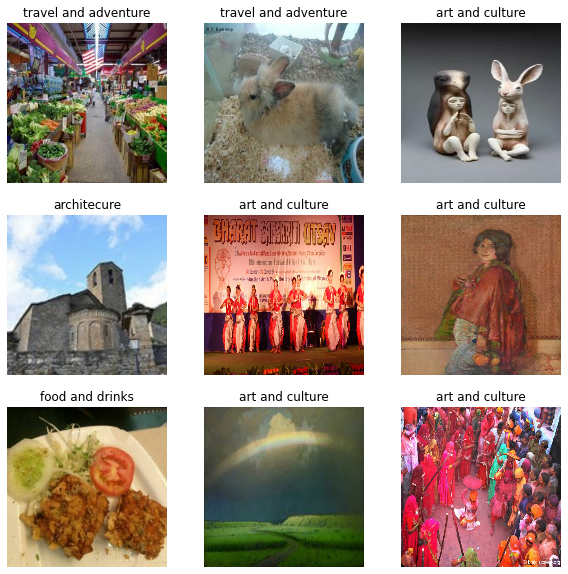

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32,)


## 성능을 높이도록 데이터세트 구성하기
### 버퍼링된 프리페치를 사용하여 I/O를 차단하지 않고 디스크에서 데이터를 생성할 수 있도록 하겠습니다. 데이터를 로드할 때 다음 두 가지 중요한 메서드를 사용해야 합니다.

### Dataset.cache()는 첫 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.

### Dataset.prefetch()는 훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다.

### 관심 있는 독자는 데이터 성능 가이드에서 두 가지 방법과 디스크에 데이터를 캐싱하는 방법에 대해 자세히 알아볼 수 있습니다.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
normalization_layer = experimental.preprocessing.Rescaling(1./255)


In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2022-06-17 11:49:37.755368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-06-17 11:49:38.093451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-06-17 11:49:39.563564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-06-17 11:49:42.723923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-06-17 11:49:43.501350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2022-06-17 11:49:44.966295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


In [ ]:
num_classes = 4

model = Sequential([
    experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(rate=0.5),
    Dense(64, activation='relu'),
    Dropout(rate=0.5),
    Dense(32, activation='relu'),
    Dropout(rate=0.5),
    Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

In [ ]:
epochs=10
es = EarlyStopping(patience=5, restore_best_weights=True)
cp = ModelCheckpoint('/Users/syshin/Desktop/Himedia/Himedia_project/image_classification/best_model1.h5')

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[es,cp]
)

In [ ]:
test_result = model.evaluate(val_ds)
test_result

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1) ## 1,행 2열의 도표, 1열
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train_acc', 'test_acc'])

plt.subplot(1,2,2,) ## 1행2열의 도표, 2열
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'test_loss'])

In [ ]:
train_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=64)

In [ ]:
val_ds = image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=64)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

In [ ]:
model1_2 = Sequential([
  experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(64, activation='relu'),
  Dense(num_classes)
])

In [ ]:
model1_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model1_2.summary()

In [ ]:
epochs=10
es1_2 = EarlyStopping(patience=5, restore_best_weights=True)
cp1_2 = ModelCheckpoint('/Users/syshin/Desktop/Himedia/Himedia_project/image_classification/best_model1_2.h5')

history1_2 = model1_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[es1_2,cp1_2]
)

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1) ## 1,행 2열의 도표, 1열
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train_acc', 'test_acc'])

plt.subplot(1,2,2,) ## 1행2열의 도표, 2열
plt.plot(history1_2.history['loss'])
plt.plot(history1_2.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'test_loss'])

In [ ]:
with tf.device('/CPU:0'):
    data_augmentation = Sequential(
      [
        experimental.preprocessing.RandomFlip("horizontal", 
                                                     input_shape=(img_height, 
                                                                  img_width,
                                                                  3)),
        experimental.preprocessing.RandomRotation(0.1),
        experimental.preprocessing.RandomZoom(0.1),
      ]
    )
    plt.figure(figsize=(10, 10))
    for images, _ in train_ds.take(1):
      for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
num_classes = 4

model2 = Sequential([
  data_augmentation,
  experimental.preprocessing.Rescaling(1./255),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Dropout(0.2),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model2.summary()

In [ ]:
es2 = EarlyStopping(patience=3, restore_best_weights=True)
cp2 = ModelCheckpoint('/Users/syshin/Desktop/Himedia/Himedia_project/image_classification/best_model2.h5')

epochs = 15
history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[es2,cp2]
)

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1) ## 1,행 2열의 도표, 1열
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train_acc', 'test_acc'])

plt.subplot(1,2,2,) ## 1행2열의 도표, 2열
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'test_loss'])

## 픽셀 값 재조정

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

## 전이학습

### 전이학습(MobileNetV2)

In [ ]:
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)

In [ ]:
# Pre-trained 모델 가져오기
from tensorflow.keras.applications import MobileNetV2
mobile_net = MobileNetV2(include_top=False, weights='imagenet', 
                 input_shape=IMG_SHAPE ,classes=4)  

In [ ]:
### 딥러닝 학습 레이어를 쌓아준다.
### 입력--히든--출력 순서대로 쌓아준다.
### 입력(1개)-- 1차원이여야함.
num_classes=4
base_model = Sequential()
base_model.add(mobile_net) 
base_model.add(Flatten()) ## 이미지 데이터를 1차원으로 만들어주는 객체 
### 히든
base_model.add(Dense(128, activation='relu'))
base_model.add(Dropout(rate=0.3))
base_model.add(Dense(64, activation='relu'))
base_model.add(Dropout(rate=0.3))
base_model.add(Dense(32, activation='relu'))
base_model.add(Dropout(rate=0.3))
base_model.add(Dense(12, activation='relu'))
base_model.add(Dropout(rate=0.3))


### 출력(1개)— 딥러닝하는 학습의 종류에 따라 다르게 써주어야 함.!!
### 이진 분류인 경우(1, sigmoid)
### 다중 분류인 경우(n, softmax)
### 회귀인 경우(1, linear)
base_model.add(Dense(4, activation='softmax'))
base_model.summary()

In [ ]:
base_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
initial_epochs = 10

loss0, accuracy0 = base_model.evaluate(val_ds)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
### 딥러닝 학습 레이어를 쌓아준다.
### 입력--히든--출력 순서대로 쌓아준다.
### 입력(1개)-- 1차원이여야함.
transfered_model = Sequential()
transfered_model.add(mobile_net) 
transfered_model.add(Flatten()) ## 이미지 데이터를 1차원으로 만들어주는 객체 
### 히든
transfered_model.add(Dense(128, activation='relu'))
transfered_model.add(Dropout(rate=0.3))
transfered_model.add(Dense(64, activation='relu'))
transfered_model.add(Dropout(rate=0.3))
transfered_model.add(Dense(32, activation='relu'))
transfered_model.add(Dropout(rate=0.3))
transfered_model.add(Dense(12, activation='relu'))
transfered_model.add(Dropout(rate=0.3))
transfered_model.add(Dense(5, activation='relu'))
transfered_model.add(Dropout(rate=0.3))

### 출력(1개)— 딥러닝하는 학습의 종류에 따라 다르게 써주어야 함.!!
### 이진 분류인 경우(1, sigmoid)
### 다중 분류인 경우(n, softmax)
### 회귀인 경우(1, linear)
transfered_model.add(Dense(4, activation='softmax'))
transfered_model.summary()

In [ ]:
base_learning_rate = 0.0001
transfered_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
transfered_model.summary()


In [ ]:
len(transfered_model.trainable_variables)

In [ ]:
initial_epochs = 10

loss0, accuracy0 = transfered_model.evaluate(val_ds)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
es_transfered = EarlyStopping(patience=5, restore_best_weights=True)
cp_transfered = ModelCheckpoint('/Users/syshin/Desktop/Himedia/Himedia_project/image_classification/mobile_net_model.h5')
transfered_history = transfered_model.fit(train_ds,
                                          epochs=initial_epochs,
                                          validation_data=val_ds,
                                          callbacks=[es_transfered,cp_transfered]
                                         )

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1) ## 1,행 2열의 도표, 1열
plt.plot(transfered_history.history['accuracy'])
plt.plot(transfered_history.history['val_accuracy'])
plt.title('model acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train_acc', 'test_acc'])

plt.subplot(1,2,2,) ## 1행2열의 도표, 2열
plt.plot(transfered_history.history['loss'])
plt.plot(transfered_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'test_loss'])

### 전이학습(ResNet50)

In [ ]:
# Pre-trained 모델 가져오기
from tensorflow.keras.applications import ResNet50
cnn_base = ResNet50(include_top=False, weights='imagenet', 
                 input_shape=IMG_SHAPE ,classes=4)  

In [ ]:
### 딥러닝 학습 레이어를 쌓아준다.
### 입력--히든--출력 순서대로 쌓아준다.
### 입력(1개)-- 1차원이여야함.
num_classes=4
model_ResNet = Sequential()
model_ResNet.add(cnn_base) 
model_ResNet.add(Flatten()) ## 이미지 데이터를 1차원으로 만들어주는 객체 
### 히든
model_ResNet.add(Dense(128, activation='relu'))
model_ResNet.add(Dropout(rate=0.3))
model_ResNet.add(Dense(64, activation='relu'))
model_ResNet.add(Dropout(rate=0.3))
model_ResNet.add(Dense(32, activation='relu'))
model_ResNet.add(Dropout(rate=0.3))
model_ResNet.add(Dense(12, activation='relu'))
model_ResNet.add(Dropout(rate=0.3))


### 출력(1개)— 딥러닝하는 학습의 종류에 따라 다르게 써주어야 함.!!
### 이진 분류인 경우(1, sigmoid)
### 다중 분류인 경우(n, softmax)
### 회귀인 경우(1, linear)
model_ResNet.add(Dense(4, activation='softmax'))
model_ResNet.summary()

In [ ]:
len(model_ResNet.trainable_variables)

In [ ]:
model_ResNet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
initial_epochs = 10

loss0, accuracy0 = model_ResNet.evaluate(val_ds)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
es_transfered_ResNet = EarlyStopping(patience=5, restore_best_weights=True)
cp_transfered_ResNet = ModelCheckpoint('/Users/syshin/Desktop/Himedia/Himedia_project/image_classification/ResNet_model.h5')
transfered_history_ResNet = model_ResNet.fit(train_ds,
                                          epochs=initial_epochs,
                                          validation_data=val_ds,
                                          callbacks=[es_transfered_ResNet,cp_transfered_ResNet]
                                         )

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1) ## 1,행 2열의 도표, 1열
plt.plot(transfered_history_ResNet.history['accuracy'])
plt.plot(transfered_history_ResNet.history['val_accuracy'])
plt.title('model acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train_acc', 'test_acc'])

plt.subplot(1,2,2,) ## 1행2열의 도표, 2열
plt.plot(transfered_history_ResNet.history['loss'])
plt.plot(transfered_history_ResNet.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'test_loss'])

## 학습곡선 시각화

In [ ]:
acc = transfered_history.history['accuracy']
val_acc = transfered_history.history['val_accuracy']

loss = transfered_history.history['loss']
val_loss = transfered_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 최상위 층 고정 해제


In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
transfered_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
transfered_model.summary()


In [ ]:
len(model.trainable_variables)


In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
es_fine = EarlyStopping(patience=5, restore_best_weights=True)
cp_fine = ModelCheckpoint('/Users/syshin/Desktop/Himedia/Himedia_project/image_classification/fine_model1.h5')

history_fine = transfered_model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         callbacks=[es_fine,cp_fine]
                        )

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = transfered_model.evaluate(val_ds)
print('Test accuracy :', accuracy)

## test

In [ ]:
import glob

In [ ]:
def make_file(data_height, data_width, channel_n, data_list_len, img_in_folder): # 높이, 너비, 컬러, 리스트 길이
    # 4차원으로 만들기 위한 4차원 리스트 필요
    print("make_file img_in_folder>>", img_in_folder)
    images=np.zeros((data_list_len, data_height, data_width, channel_n))
    # 이미지 리스트에서 하나씩 꺼내서 라벨링, 스케일링, 리사이징
    for i, image in enumerate(img_in_folder):     
        # 읽어서 스케일링, 리사이징 
        image=cv2.imread(image) /255 #읽기, 스케일링
        image=cv2.resize(image, (data_height, data_width)) #리사이징
        # 4차원 리스트에 하나씩 append
        images[i, :, :, :]=image
    return images

In [ ]:
os.chdir('/Users/syshin/Desktop/Himedia/Himedia_project/image_classification/archive (1)/test/sort copy')
img_in_folder = glob.glob('*.*')

In [ ]:
batch_size = 32
data_height = 160
data_width = 160

images = make_file(data_height, data_width, channel_n, len(img_in_folder), img_in_folder)
predictions = transfered_model.predict(images)


In [ ]:

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[np.argmax(predictions[i])])
  plt.axis("off")